In [1]:
import numpy as np
import random
import time
import sklearn
import sklearn.metrics
tol = 10^-8

In [2]:
def kernel_expo(x,y,gamma):
    return np.exp(-gamma*(np.linalg.norm(x-y)**2))

In [3]:
def KKTviol(O,rho,mu,l,alpha,ens):
    ens2 = np.where(np.logical_or((rho-O[ens])*(1/(mu*l)-alpha[ens])>0, (O[ens]-rho)*alpha[ens]>0))
    #print(ens2[0])
    #np.random.shuffle(ens)
    #p = -1
    #for index in ens:
    #    if (O[index] -rho)*alpha[index]>0 or (rho-O[index])*(1/(mu*l)-alpha[index])>0:
            #print((O[index] -rho)*alpha[index],(rho-O[index])*(1/(mu*l)-alpha[index]),alpha[index])
    #        p = index
    
    if len(ens2[0]) == 0:
        return -1
    else :
        index = np.random.randint(len(ens2[0]))
        return ens2[0][index]
    #return p

In [4]:
def argmax(O,i,ens):
    index = 0
    value = 0
    ens = list(ens)
    Oens = O[ens]
    return ens[np.argmax(O[i]-Oens)]

In [5]:
def optim(alpha,i,j,K,O,mu,l):
    delta = alpha[i]+alpha[j]
    Ci = O[i] - alpha[i]*K[i,i] -alpha[j]*K[i,j]
    Cj = O[j] - alpha[i]*K[i,j] -alpha[j]*K[j,j]
    # Condition droite (inutile dans le cas du noyau gaussien)
    if K[i,i]+K[j,j]-2*K[i,j] == 0:
        if Cj-Ci-K[i,i]>0:
            alphaj = max(0,delta-1/(l*mu))
            alphai = delta - alphaj
        elif Cj-Ci-K[i,i] <0:
            alphaj = min(1/(l*mu),delta)
            alphai = delta - alphaj
        else :
            alphaj = alpha[j]
            alphai = alpha[i]
    else:
        xmin =  (delta*(K[i,i]-K[i,j])+Ci-Cj)/( K[i,i]+K[j,j]-2*K[i,j])
        
        # condition si le min n'est pas atteint dans 0 1/(l*mu)
        # condition sur K inutile si noyau gaussien
        if K[i,i]+K[j,j]-2*K[i,j] < 0 or xmin <max(0,delta-1/(mu*l)) or xmin > min(1/(mu*l),delta):
            #print("sur les bords",K[i,i]+K[j,j]-2*K[i,j],xmin)
            #time.sleep(1)
            x0 = max(0,delta-1/(l*mu))
            fx0  = 1/2*(delta-x0)**2*K[i,i] + (delta-x0)*K[i,j] + 1/2*x0**2*K[j,j] + (delta-x0)*Ci + x0*Cj
            xmu = min(1/(l*mu),delta)
            fxmu  = 1/2*(delta-xmu)**2*K[i,i] + (delta-xmu)*K[i,j] + 1/2*xmu**2*K[j,j] + (delta-xmu)*Ci + xmu*Cj
            if fx0 > fxmu:
                alphaj = xmu
                alphai = delta - alphaj
            else :
                alphaj = x0
                alphai = delta - alphaj
        else :
            #print("A l'intérieur",xmin)
            #time.sleep(1)
            alphaj = xmin
            alphai = delta - alphaj
        """
        alphaj = alpha[j] + (O[i]-O[j])/(K[i,i]+K[j,j]-2*K[i,j])
        if alphaj < 0:
            alphaj = 0
        if alphaj >1/(l*mu):
            #print("l",l,mu)
            alphaj = 1/(l*mu)
        delta = alpha[i]+alpha[j]
        alphai = delta - alphaj
        """
    alphai = delta - alphaj
    #print(alphai,alphaj)
    #print("alphai , alphaj : ",alphai,alphaj,alpha[i],alpha[j] , " delta : ", delta)
    if alpha[i]+alpha[j] - (alphai + alphaj)>10**(-8):
        print("delta : ",alpha[i]+alpha[j], alphai + alphaj)
        print(alpha[i],alpha[j],alphai,alphaj)
    if alphai<0 or alphaj <0 or alphai >1/(mu*l) or alphaj >1/(mu*l):
        print("oups",alphai,alphaj)
    return alphai,alphaj
    

In [6]:
def SVcalc(alpha,c):
    return list(np.where((alpha>0))[0])#&(alpha<c))[0])

In [40]:
class osvm:
    def __init__(self,mu=0.01,maxiter=200,eps=0.001,gamma=5):
        assert mu>0,"mu doit être strictement positif"
        assert mu<=1,"mu doit être inférieur à 1"
        self.mu = mu
        self.eps = eps
        self.maxiter = maxiter
        self.gamma = gamma
        self.time_init = 0
        self.time_kkt = 0
        self.time_O = 0
        self.time_sv = 0
        self.time_argmax = 0
        self.len_sv = []
        self.index_hist = []
        self.O_hist = []
        self.diff_hist = []
        self.diffi_hist = []
        self.lenOsv = []
        self.sv_hist = []
        self.diffindex_hist = []
        self.rho_hist = []
        
    def fit(self,data):
        print("Initialisation")
        timer = time.clock()
        self.alpha = np.zeros(np.shape(data)[0])
        self.l = np.shape(data)[0] 
        l = self.l
        self.data = data
        K = np.array([[kernel_expo(x,y,self.gamma) for x in data] for y in data])
        choose = [i for i in range(l)]
        self.rho = 0
        s = 0
        while s <= 1-1/(l*self.mu):
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1/(l*self.mu)
            s += 1/(l*self.mu)
        if s != 1:
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1-s
            #print(1-s)
            s = 1
        #C = np.dot(self.alpha[2:],K[2:,:])
        self.time_init += time.clock()-timer
        timer = time.clock()
        O = np.dot(self.alpha,K)
        self.time_O += time.clock()-timer
        self.rho = max(O[self.alpha>0])
        self.rho_hist.append(self.rho)
        #print(sum(self.alpha))
        print("Apprentissage")
        iter_etape = 0
        iteration = 0
        while iteration < self.maxiter:
            
            # Etape (i)
            timer = time.clock()
            enskkt = list(range(l))
            np.random.shuffle(enskkt)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,enskkt)
            self.time_kkt += time.clock() - timer
            iteration += 1
            if index == -1:
                print(iteration,"break index")
                break
            
            timer = time.clock()
            SV = SVcalc(self.alpha,1/(self.mu*l))
            self.time_sv += time.clock() - timer
            
            """if SV == []:
                SV_rand = np.random.randint(len(self.alpha))
                while SV_rand == index:
                    SV_rand = np.random.randint(len(self.alpha))
                SV = [SV_rand]"""
            while index in SV:
                    SV.remove(index)
            if SV == []:
                print("SV empty")
                continue
            
            self.time_argmax -= time.clock()
            j = argmax(O,index,SV)
            self.time_argmax += time.clock()
            #print("before",self.alpha[index],self.alpha[j])
            alpha_index,alpha_j = self.alpha[index],self.alpha[j]
            self.alpha[index],self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
            if sum(self.alpha) > 1.001:
                print("etape i " ,sum(self.alpha))
                time.sleep(0.5)
            #print("after",self.alpha[index],self.alpha[j])
            
            # update de rho
            self.time_O -= time.clock()
            O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
            self.rho = max(O[(self.alpha>0)])
            self.rho_hist.append(self.rho)
            self.time_O += time.clock()
            self.time_sv -= time.clock()
            SV = SVcalc(self.alpha,1/(self.mu*l))
            self.time_sv += time.clock()
            
            # Etape (ii)
            self.time_kkt -= time.clock()
            np.random.shuffle(SV)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
            self.time_kkt += time.clock()
            maxiterii = 1000
            iterii = 0
            while index !=-1 and len(SV)>=1 and iterii < maxiterii:
                iterii += 1
                iter_etape += 1
                while index in SV:
                    SV.remove(index)
                if SV != []:
                    self.len_sv.append(len(SV))
                    self.index_hist.append(index)
                    self.time_argmax -= time.clock()
                    j = argmax(O,index,SV)
                    Osv = O[index] - O
                    self.diff_hist.append(max(abs(Osv[SV])))
                    self.diffi_hist.append(np.argmax(abs(Osv[SV])))
                    self.diffindex_hist.append(index)
                    self.lenOsv.append(len(Osv[SV]))
                    self.sv_hist.append(SV)
                    self.time_argmax += time.clock()
                    #print("j " , j)
                    #time.sleep(0.5)
                    #print("before",self.alpha[index],self.alpha[j])
                    delta = self.alpha[index] + self.alpha[j]
                    #self.alpha[index],self.alpha[j] 
                    alpha_index,alpha_j = self.alpha[index],self.alpha[j]
                    self.alpha[index] , self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
                    #if sum(self.alpha) > 1.001:
                    #    print("etape ii " ,sum(self.alpha))
                    #    print(index,j)
                    #    print(self.alpha[index] + self.alpha[j] , delta, alpha_index + alpha_j)
                    #    print(SV)
                    #    time.sleep(0.5)
                    #print("after",self.alpha[index],self.alpha[j])
                    #time.sleep(0.5)
                    # update de rho
                    #print(np.size(self.alpha),np.size(K))
                    self.time_O -= time.clock()
                    O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
                    try:
                        self.rho = max(O[ (self.alpha>0)])
                        self.rho_hist.append(self.rho)
                    except:
                        print("rho break")
                        break
                    self.time_O += time.clock()
                    self.O_hist.append(np.linalg.norm(K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)))
                    self.O = O
                    self.K = K
                else:
                    print("SV empty")
                    
                
                #print(index)
                self.time_sv -= time.clock()
                SV = SVcalc(self.alpha,1/(self.mu*l))
                self.time_sv += time.clock()
                if len(SV) == 1:
                    print("len sv break")
                    break
                #print(" longueur sv " ,len(SV))
                self.time_kkt -= time.clock()
                np.random.shuffle(SV)            
                index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
                self.time_kkt += time.clock()
                while index in SV:
                    SV.remove(index)
                
            #if iterii == maxiterii :
            #    continue
                """
                rargmax = 0
                rmax = 0
                for i in range(len(self.alpha)):
                    alp = self.alpha[i]
                    if alp >0 and alp < 1*(self.mu*l):
                        print(O[i])
                        if O[i]> rmax:
                            rmax = O[i]
                            rargmax = i
                            """
                #print(min(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]),max(O[ (self.alpha>0)& (self.alpha < 1/(self.mu*l)) ]))
                #print("sum : " , sum(self.alpha))
                #print(self.rho,rargmax,O[rargmax],self.alpha[rargmax],rmax)
            if iteration%10 == 0 :
                print(iter_etape,iteration,self.maxiter,self.rho,np.dot(self.alpha,np.dot(self.alpha,K)))
                iter_etape = 0
        #return self.alpha,self.rho    
    
    def predict(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.sign(np.dot(self.alpha,K)-self.rho)
    
    def decision_function(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.dot(self.alpha,K)-self.rho

In [31]:
data = 2*(-0.5 + np.random.rand(1000))

In [45]:
test = osvm(0.01,gamma = 10)
test.fit(data)

Initialisation
Apprentissage
10000 10 200 0.356199854165 0.280125385071
10000 20 200 0.314281633404 0.26393758985
10000 30 200 0.320619403188 0.263321111023
10000 40 200 0.310012373145 0.256180640197
10000 50 200 0.310012373145 0.256180640197
10000 60 200 0.310012373145 0.256180640197
10000 70 200 0.310012373145 0.256180640197
10000 80 200 0.311932646494 0.256142457398
10000 90 200 0.311932646494 0.256142457398
10000 100 200 0.3139172612 0.255897380421
10000 110 200 0.313639398436 0.255880597751
10000 120 200 0.313061453439 0.255805390222
10000 130 200 0.313061453439 0.255805390222
10000 140 200 0.313061453439 0.255805390222
10000 150 200 0.315380630761 0.25573359279
10000 160 200 0.315683694379 0.255617311943
10000 170 200 0.324694768122 0.249888297883
10000 180 200 0.324694768122 0.249888297883
10000 190 200 0.324694768122 0.249888297883
10000 200 200 0.324694768122 0.249888297883


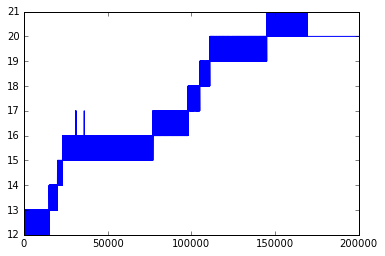

In [46]:
plt.plot(test.len_sv)
#plt.plot(test.lenOsv,'r')
plt.show()

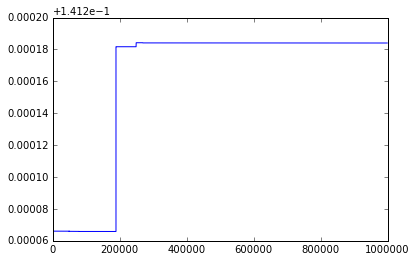

In [34]:
plt.plot(test.rho_hist[1000:])
#plt.plot(test.lenOsv,'r')
plt.show()

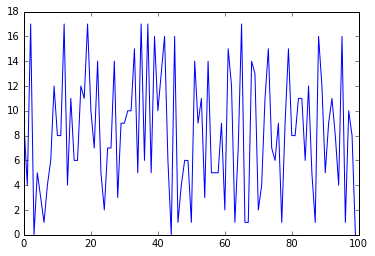

In [22]:
plt.plot(test.diffindex_hist[-100:])
#plt.plot(test.lenOsv,'r')
plt.show()

In [23]:
# probleme de la projection de alpha1 et alpha2
#return alpha?
print(np.histogram(test.len_sv,bins = [i for i in range(100)]))

(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0, 31004,   491,  3116,  4584,  9167,  7622, 31440,
       12576,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0], dtype=int64), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

In [24]:
print(np.where(np.histogram(test.index_hist,bins = [i for i in range(1000)])[0]>0))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int64),)


In [25]:
print(np.where(test.alpha>0))

(array([ 24,  98, 125, 191, 222, 336, 427, 454, 477, 638, 679, 837, 843,
       855, 875, 924, 938, 955], dtype=int64),)


In [26]:
test.alpha[test.alpha>0]

array([ 0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.00157832,
        0.1       ,  0.1       ,  0.1       ,  0.02153413,  0.00313686,
        0.00318867,  0.1       ,  0.01154769,  0.00043242,  0.00122312,
        0.1       ,  0.00724541,  0.05011338])

In [27]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

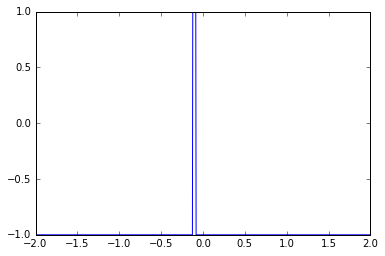

In [47]:
x=np.linspace(-2,2,1000)
y = test.predict(x)
plt.plot(x,y)

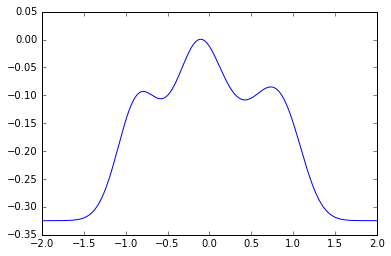

In [48]:
y = test.decision_function(x)
plt.plot(x,y)

In [11]:
xtest=np.linspace(-1,1,1000)

In [24]:
nb = 0
for x in xtest:
    if test.predict(x)<0 :
        nb += 1


In [25]:
nb

7

In [18]:
124/1000

0.124

KeyboardInterrupt: 

In [94]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = osvm(0.01)
clf.fit(X_train)


Initialisation
Apprentissage


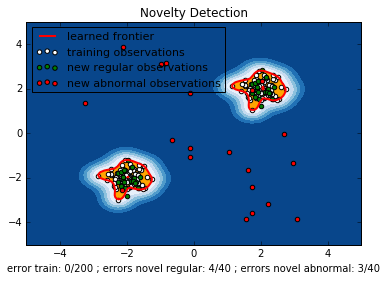

In [95]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [63]:
n_error_outliers

0